# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const
import time
import astropy.units as u

import os,sys
gwent_path = '/Users/andrewkaiser/Documents/GradSchool/Research/gwent'

sys.path.insert(0,gwent_path)
import gwent
from gwent import binary
from gwent import detector
from gwent import snr
from gwent import snrplot

Setting matplotlib preferences

In [4]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = False
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

We need to get the file directories to load in the instrument files.

In [5]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

import os
save_snr_location = os.getcwd() + '/saved_SNRs/'
print(save_snr_location)

/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/notebook_examples/saved_SNRs/


## Declaring x and y variables and Sample Rates

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* GroundBased ONLY:

    * Any single valued variable in list of params given by:
        instrument_GroundBased.Get_Noise_Dict()
    * To make variable in SNR, declare the main variable, then the subparameter variable
        as a string e.g. var_x = 'Infrastructure Length', the case matters.
    
* SpaceBased ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IFO' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IFO_break' - The Optical Metrology Noise Break Frequency
    
* PTA ONLY:

    * 'N_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

In [6]:
#Number of SNRMatrix rows
sampleRate_y = 50
#Number of SNRMatrix columns
sampleRate_x = 50

## Source Selection Function

Takes in a an instrument model that dictates reasonable mass ranges for the particular detector mass regime and instantiates a source with the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one only needs to set the minima and maxima of the selected SNR axes variables.

In [7]:
def Get_Source(model):
    if model in [0,1,2,3]:
        #M = m1+m2 Total Mass
        M = 1e1
        M_min = 1e0
        M_max = 1e4
    elif model in [4,5,6,7,8,9,10,11,12]:
        #M = m1+m2 Total Mass
        M = 1e9
        M_min = 1e8
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 1.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

## Instrument Selection Function

Takes in an instrument model then assigns the fiducial noise and detector values. The model only assigns ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

For generating a detector, one must assign a value to each of the different instrument parameters (see the section on Declaring x and y variables and Sample Rates).

In [12]:
def Get_Instrument(model):
    if model in [0,1,2,3]:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        if model == 0: #Einstein Telescope
            #Loaded from http://www.et-gw.eu/index.php/etsensitivities
            load_name = 'ET_D_data.txt'
            load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
            instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        elif model == 1: #aLIGO
            noise_dict = {'Infrastructure':
                          {'Length':[3995,1000,1e5]},
                          'Laser':
                          {'Power':[125,10,1e3]},
                          'Seismic':
                          {'Gamma':[0.8,1e-3,1e3]}}
            instrument = detector.GroundBased('aLIGO',T_obs,noise_dict=noise_dict)
        elif model == 2: #Voyager
            noise_dict = {'Infrastructure':
                          {'Length':[3995,1000,1e5]},
                          'Laser':
                          {'Power':[144.6848,10,1e3]},
                          'Seismic':
                          {'Gamma':[0.8,1e-3,1e3]}}
            instrument = detector.GroundBased('Voyager',T_obs,noise_dict=noise_dict)
        elif model == 3: #Cosmic Explorer proposal 1
            noise_dict = {'Infrastructure':
                          {'Length':[40000,1e3,1e5]},
                          'Laser':
                          {'Power':[150,10,1e3]},
                          'Seismic':
                          {'Gamma':[0.8,1e-3,1e3]}}
            instrument = detector.GroundBased('CE1',T_obs,noise_dict=noise_dict)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model in [4,5,6,7,8]:
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 5*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        sigma_min = 100*u.ns.to('s')*u.s
        sigma_max = 500*u.ns.to('s')*u.s
        
        N_p = 18 #Number of pulsars
        N_p_min = 18
        N_p_max = 40
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        
        if model == 4: #NANOGrav 15 yr WN only
            instrument = detector.PTA('NANOGrav_WN',T_obs,N_p,sigma,cadence)
        elif model == 5: #NANOGrav 15 yr WN + RN
            instrument = detector.PTA('NANOGrav_WN_RN',T_obs,N_p,sigma,cadence,
                                      rn_amp=[1e-16,1e-12],rn_alpha=[-1/2,1.25])
        elif model == 6: #NANOGrav 15 yr WN + GWB
            instrument = detector.PTA('NANOGrav_WN_GWB',T_obs,N_p,sigma,cadence,
                                      GWB_amp=4e-16)
        elif model == 7: #NANOGrav realistic noise
            instrument = detector.PTA('NANOGrav_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
        elif model == 8: #NANOGrav 11 yr real data
            #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
            load_name = 'NANOGrav_11yr_S_eff.txt'
            load_location = load_directory + 'NANOGrav/StrainFiles/' + load_name
            T_obs = 11.42*u.yr #Observing time in years
            instrument = detector.PTA('NANOGrav_11yr',load_location=load_location,I_type='E')
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model in [9,10,11,12]: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        sigma_min = 10*u.ns.to('s')*u.s
        sigma_max = 100*u.ns.to('s')*u.s
        
        N_p = 20 #Number of pulsars
        N_p_min = 18
        N_p_max = 200
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        if model == 9: #SKA WN only
            instrument = detector.PTA('SKA_WN',T_obs,N_p,sigma,cadence)
        elif model == 10: #SKA WN + RN
            instrument = detector.PTA('SKA_WN_RN',T_obs,N_p,sigma,cadence,
                                      rn_amp=[1e-16,1e-12],rn_alpha=[-1/2,1.25])
        elif model == 11: #SKA WN + GWB
            instrument = detector.PTA('SKA_WN_GWB',T_obs,N_p,sigma,cadence,
                                      GWB_amp=4e-16)
        elif model == 12: #SKA realistic noise
            instrument = detector.PTA('SKA_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model > 12:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        A_acc = 3e-15*u.m/u.s/u.s
        A_acc_min = 1e-16*u.m/u.s/u.s
        A_acc_max = 1e-14*u.m/u.s/u.s
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_min = .1*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_max = 1.0*u.mHz.to('Hz')*u.Hz
        
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_min = 1.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_max = 10.*u.mHz.to('Hz')*u.Hz
        
        f_IFO_break = 2.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_min = 1.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_max = 10.*u.mHz.to('Hz')*u.Hz
        
        A_IFO_min = 1.0e-13*u.m
        A_IFO_max = 1.0e-10*u.m
        
        if model == 13: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
            A_IFO = 1.5e-11*u.m
            Background = False
            T_type = 'A'

            instrument = detector.SpaceBased('Alt_LISA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)

        else: #L3 proposal
            #Default Params from https://arxiv.org/abs/1702.00786
            A_IFO = 10e-12*u.m
            Background = False
            T_type = 'N'
        
            instrument = detector.SpaceBased('LISA_ESA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        instrument.A_acc = [A_acc,A_acc_min,A_acc_max]
        instrument.f_acc_break_low = [f_acc_break_low,f_acc_break_low_min,f_acc_break_low_max]
        instrument.f_acc_break_high = [f_acc_break_high,f_acc_break_high_min,f_acc_break_high_max]
        instrument.A_IFO = [A_IFO,A_IFO_min,A_IFO_max]
        instrument.f_IFO_break = [f_IFO_break,f_IFO_break_min,f_IFO_break_max]
        
    return instrument

## SNR Calculation

First we declare the parameters we want to vary on each axis, then based on the selected model (In this case the L3 LISA proposal), we use `Get_Instrument` and `Get_Source` to instantiate both the instrument and the model for the SNR Calculation.

In [78]:
sampleRate_x = 10
sampleRate_y = 10
#Variable on y-axis
var_y = 'Infrastructure Length'
#Variable on x-axis
var_x = 'M'
model = 3
instrument = Get_Instrument(model)
source = Get_Source(model)

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix and  the SNRs with size of the `sampleRate1`X`sampleRate2`

In [79]:
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,var_x,sampleRate_x,var_y,sampleRate_y)

/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/site-packages/gwinc/noise/residualgas.py:40: RuntimeWarning: invalid value encountered in sqrt
  waist = waist * sqrt(((g1*g2)*(1-g1*g2))/((g1+g2-2*g1*g2)**2))
/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/site-packages/gwinc/noise/residualgas.py:54: RuntimeWarning: invalid value encountered in less
  zint[zint < 0] = 0


Plot the SNR using the initial variables and the returns from `Get_SNR_Matrix`

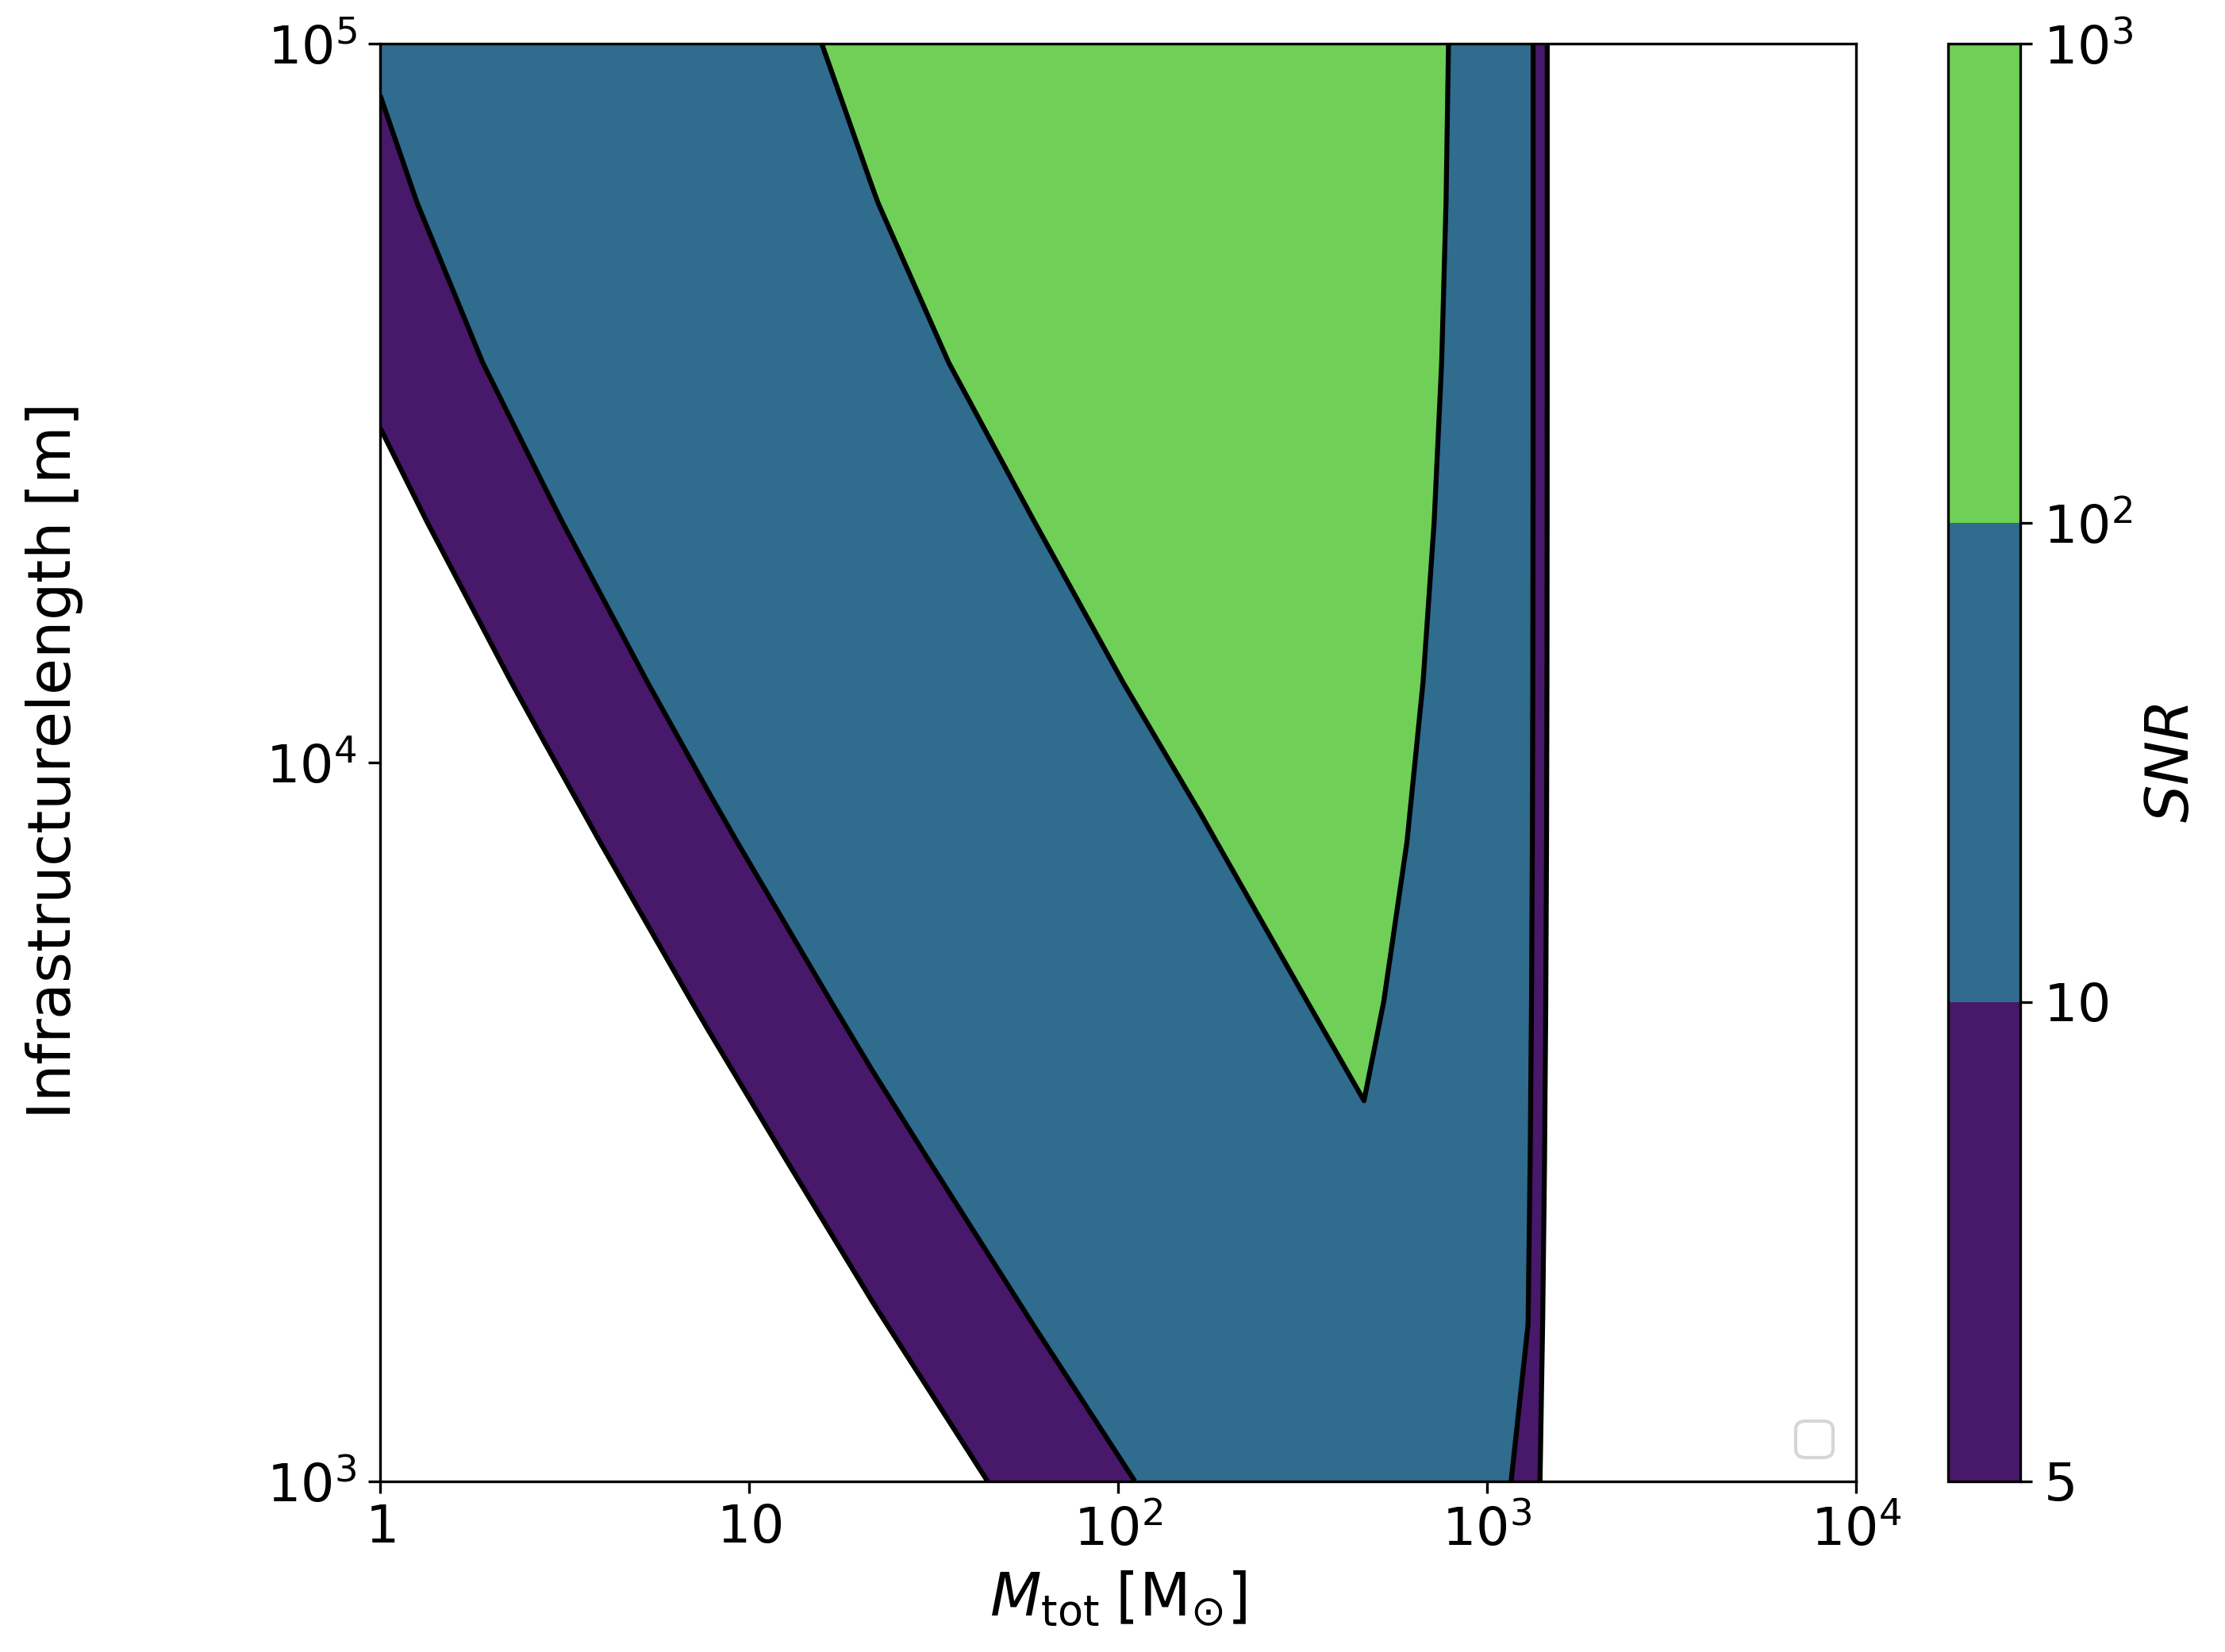

In [80]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False,display=True)

## Create of SNR Matrices and Samples for all models

### PTA Only Params

* 'N_p' - Number of Pulsars
* 'sigma' - Root-Mean-Squared Timing Error
* 'cadence' - Observation Cadence

### Global Detector Params

* 'T_obs' - Observation Time Length

In [11]:
#Variables on y-axis
var_ys = ['N_p','sigma','cadence','T_obs']
#Variable on x-axis
var_x = 'M'
#All non-loaded PTAs
models = [2,3,4,5,7,8,9,10]

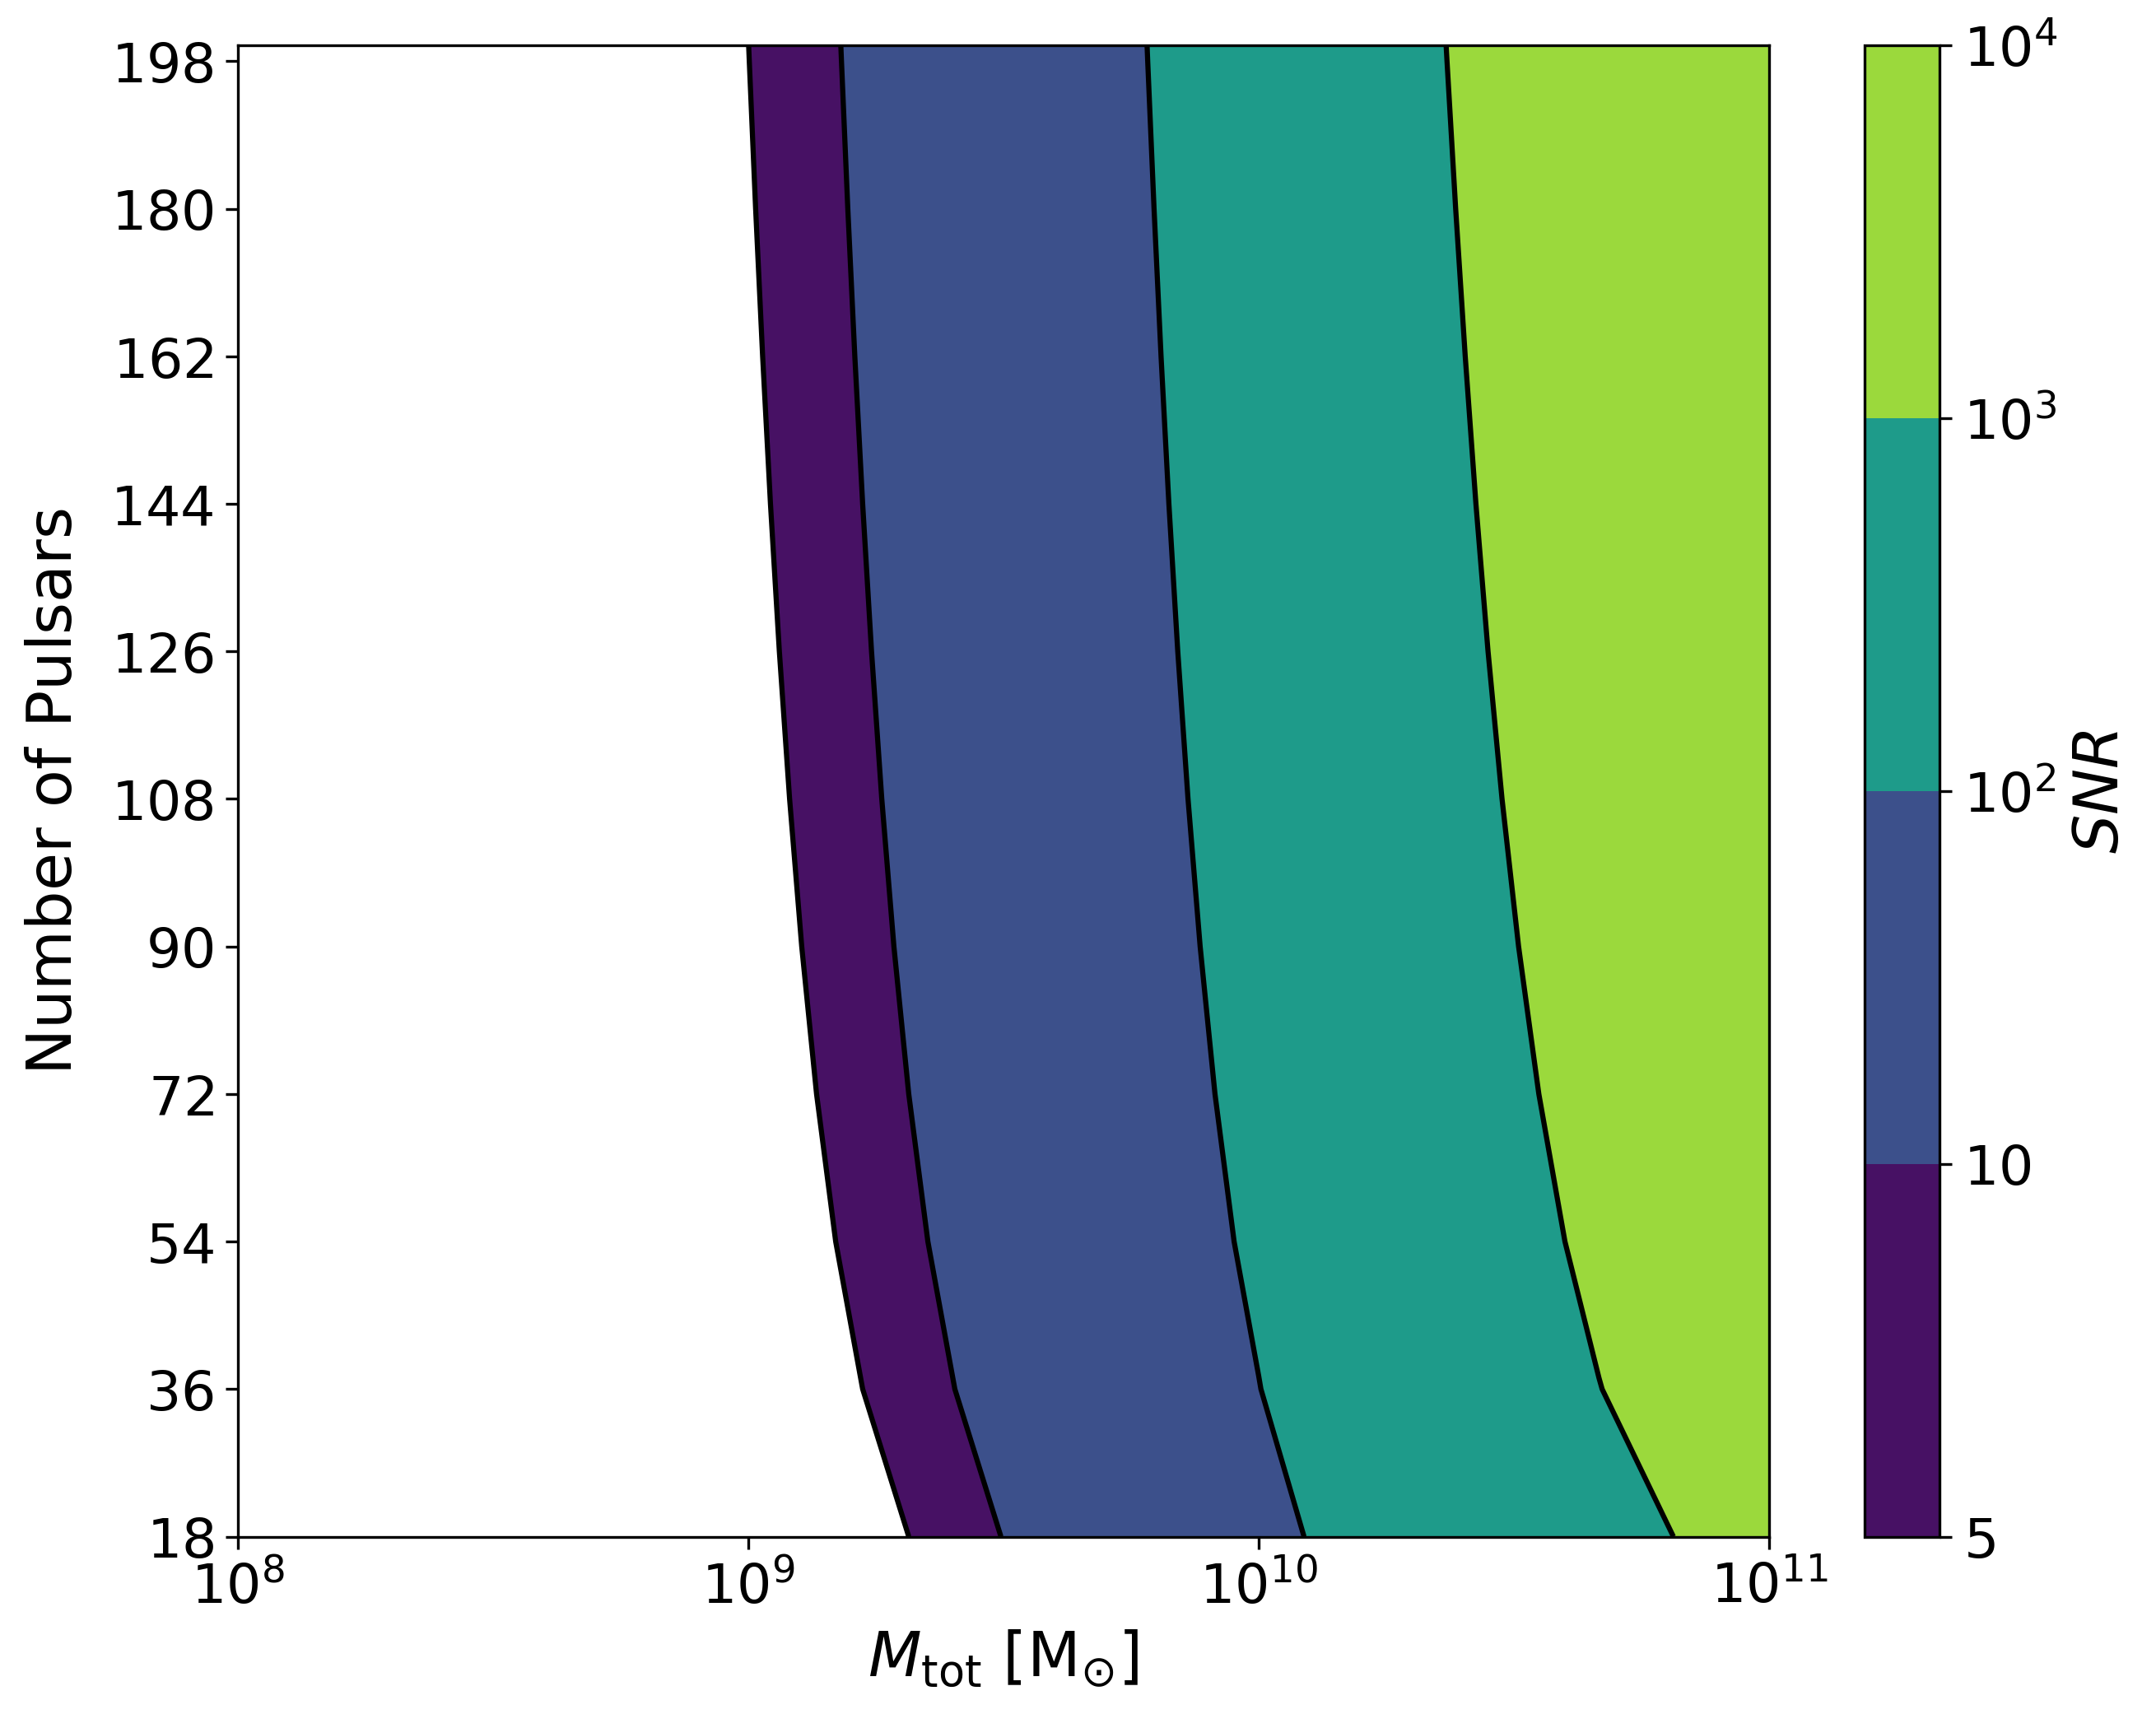

Model:  SKA_WN_GWB_M_vs_N_p ,  done. t = :  1069.8016312122345


In [ ]:
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    for var_y in var_ys:
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)
        print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

### LISA Only Params

* 'L' - Detector Armlength
* 'A_acc' - Detector Acceleration Noise
* 'A_IFO' - Detector Optical Metrology Noise
* 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
* 'f_acc_break_high' - The High Acceleration Noise Break Frequency
* 'f_IFO_break' - The Optical Metrology Noise Break Frequency

### Global Detector Params

* 'T_obs' - Observation Time Length

In [15]:
#Variables on y-axis
var_ys = ['L','A_acc','A_IFO','f_acc_break_low','f_acc_break_high','f_IFO_break','T_obs']
var_ys = ['f_acc_break_high']
#Variable on x-axis
var_x = 'M'
#LISA L3 proposal
models = [14]
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100

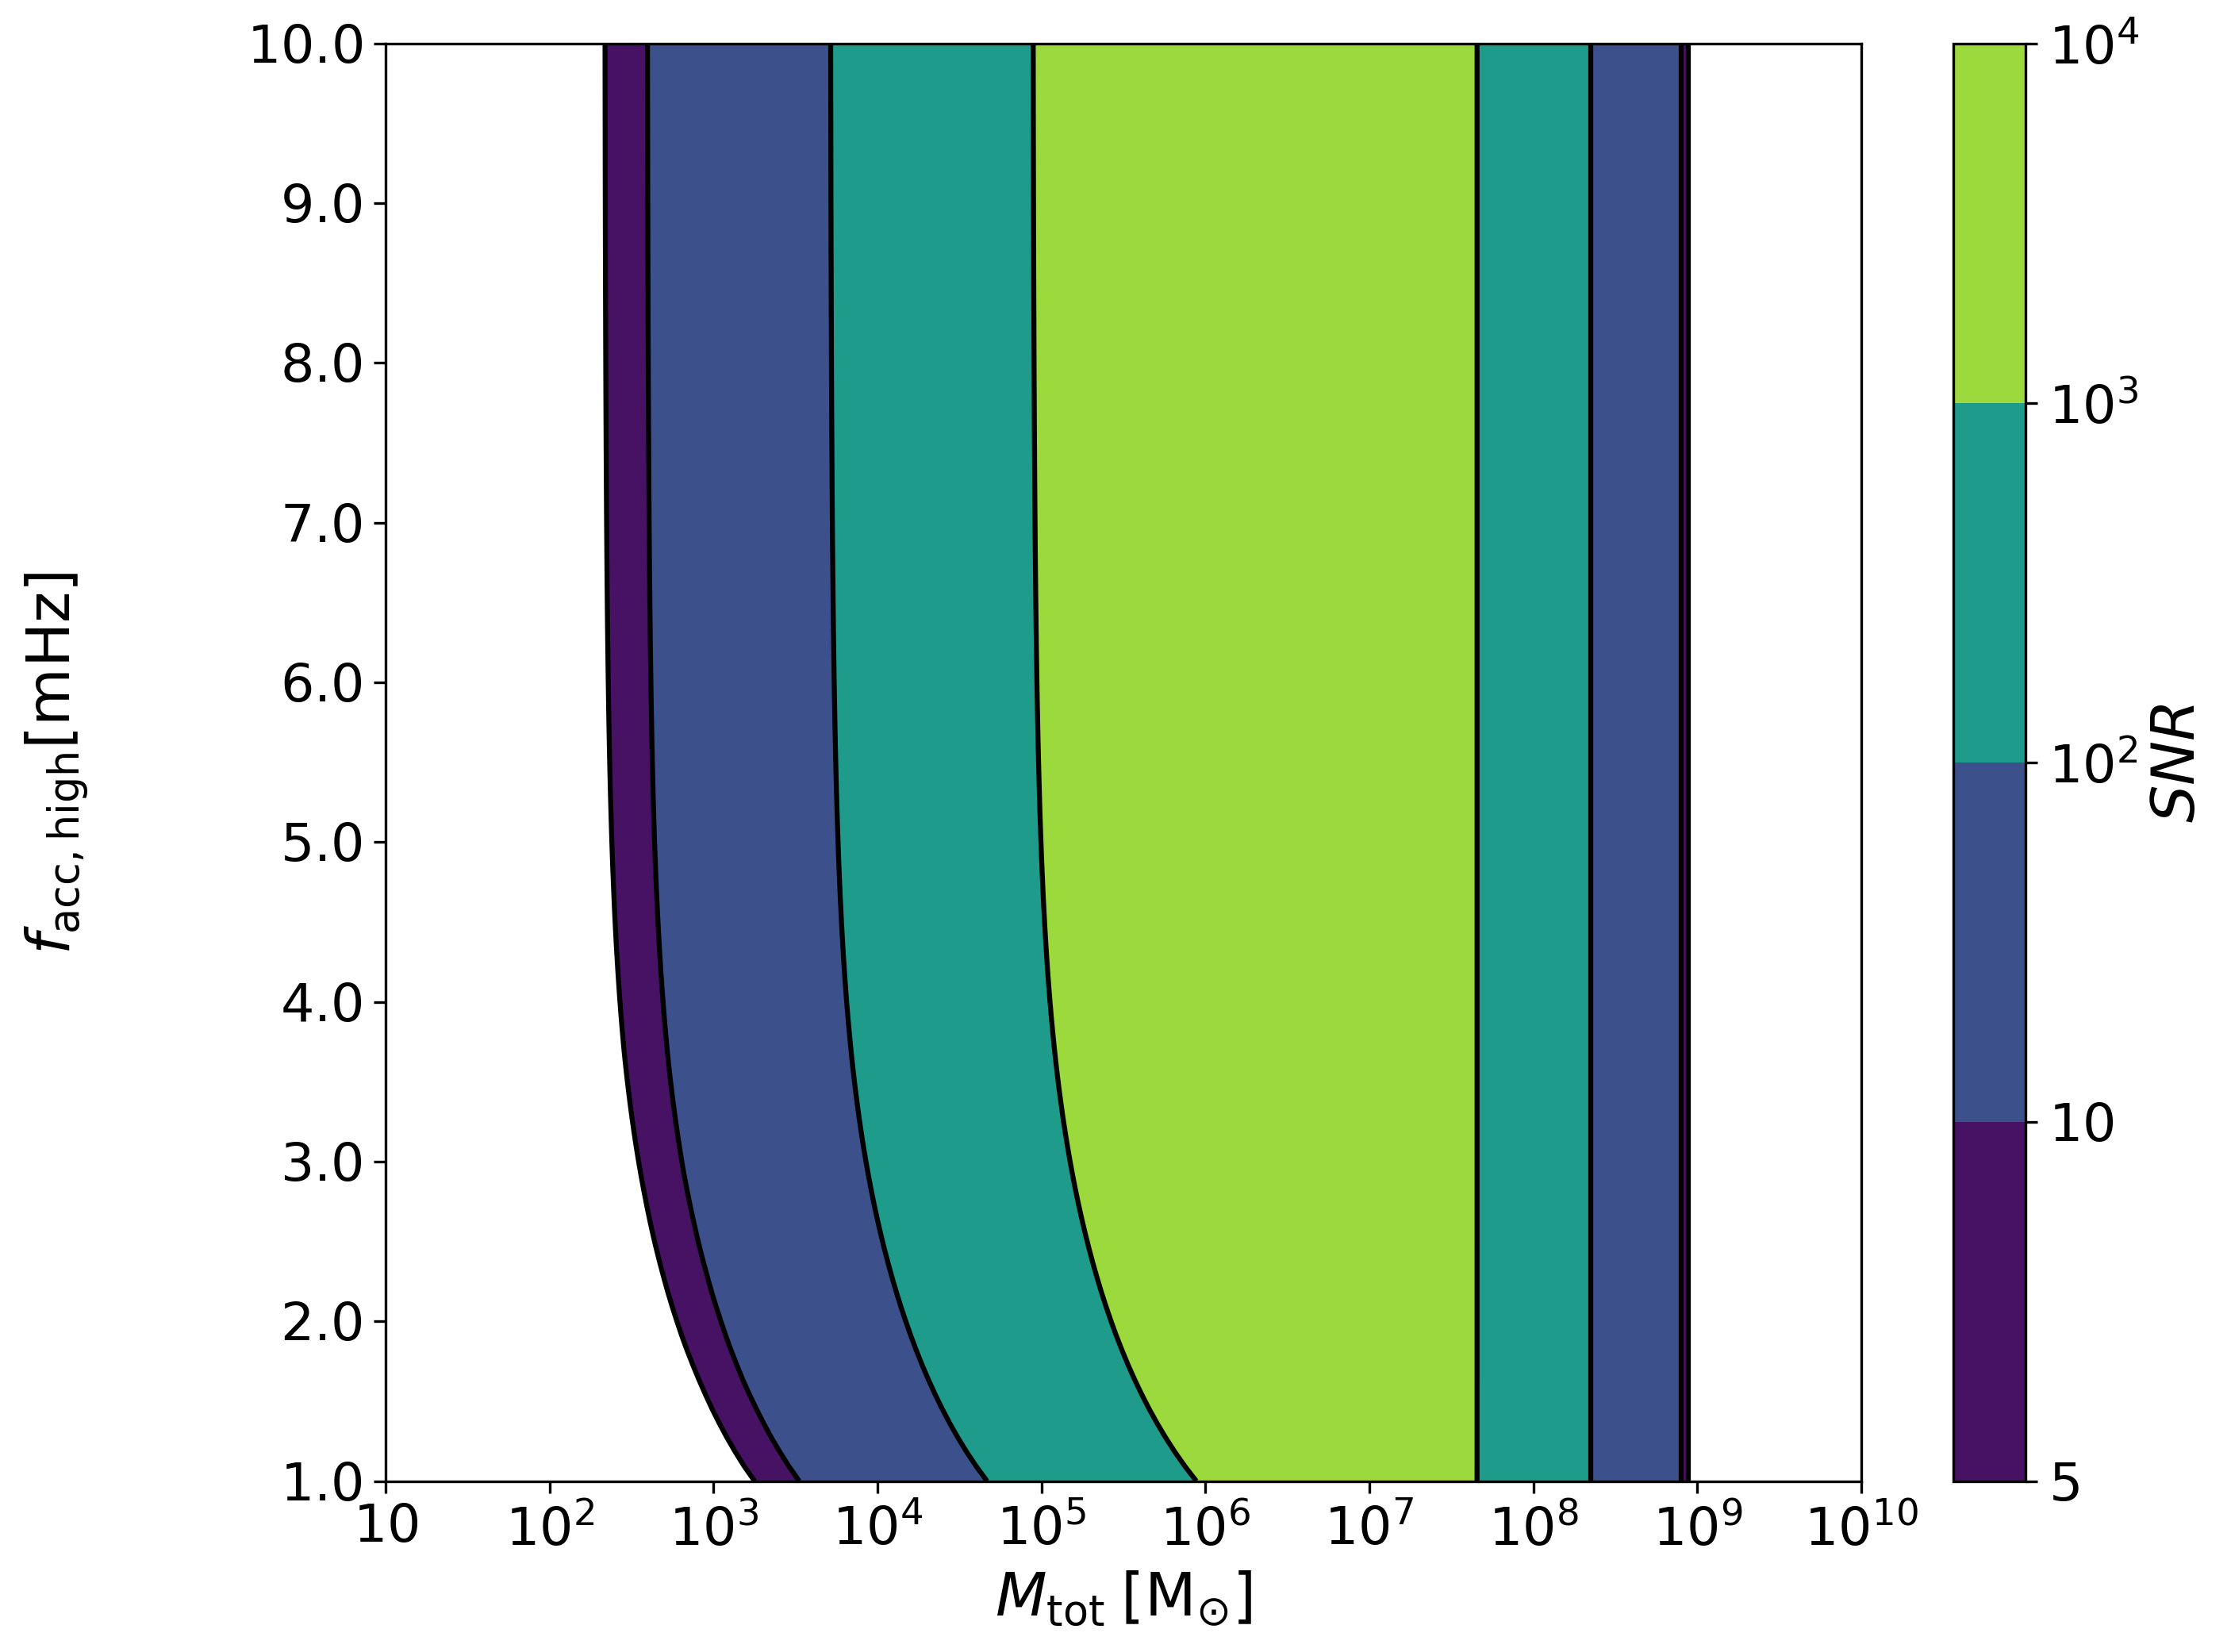

Model:  LISA_ESA_M_vs_f_acc_break_high ,  done. t = :  67.60643029212952


In [16]:
for model in models:
    for var_y in var_ys:
        instrument = Get_Instrument(model)
        source = Get_Source(model)
        var_y_names = var_y.split()
        if len(var_y_names) == 1:
            #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '.png'
            save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_SNR_v2.txt'
            save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_samples_v2.txt'
        elif len(var_y_names) == 2:
            save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + \
            '_' + var_y_names[1] + '_SNR_v2.txt'
            save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + \
            '_' + var_y_names[1] + '_samples_v2.txt'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)

        if len(var_y_names) == 1:
            print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)
        elif len(var_y_names) == 2:
            print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_' + var_y_names[1],',',' done. t = : ',end-start)

### Global Source Params for all Fiducial Detectors

* 'M' - Mass (Solar Units)
* 'q' - Mass Ratio
* 'chi1' - Dimensionless Spin of Black Hole 1
* 'chi2' - Dimensionless Spin of Black Hole 2
* 'z' - Redshift

In [ ]:
#Variable on y-axis
var_ys = ['q','chi1','z']
#Variable on x-axis
var_x = 'M'
#All Models
models = range(11)

In [ ]:
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    for var_y in var_ys:
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)
        print('Model: ',instrument.name,',',' done. t = : ',end-start)

In [83]:
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100
#Variable on y-axis
#var_ys = ['q','chi1','z','Infrastructure Length','Seismic Gamma','Laser Power']
var_ys = ['Infrastructure Length']
#Variable on x-axis
var_x = 'M'
#All Models
models = [3]

In [70]:
print(var_ys[4].split())

IndexError: list index out of range

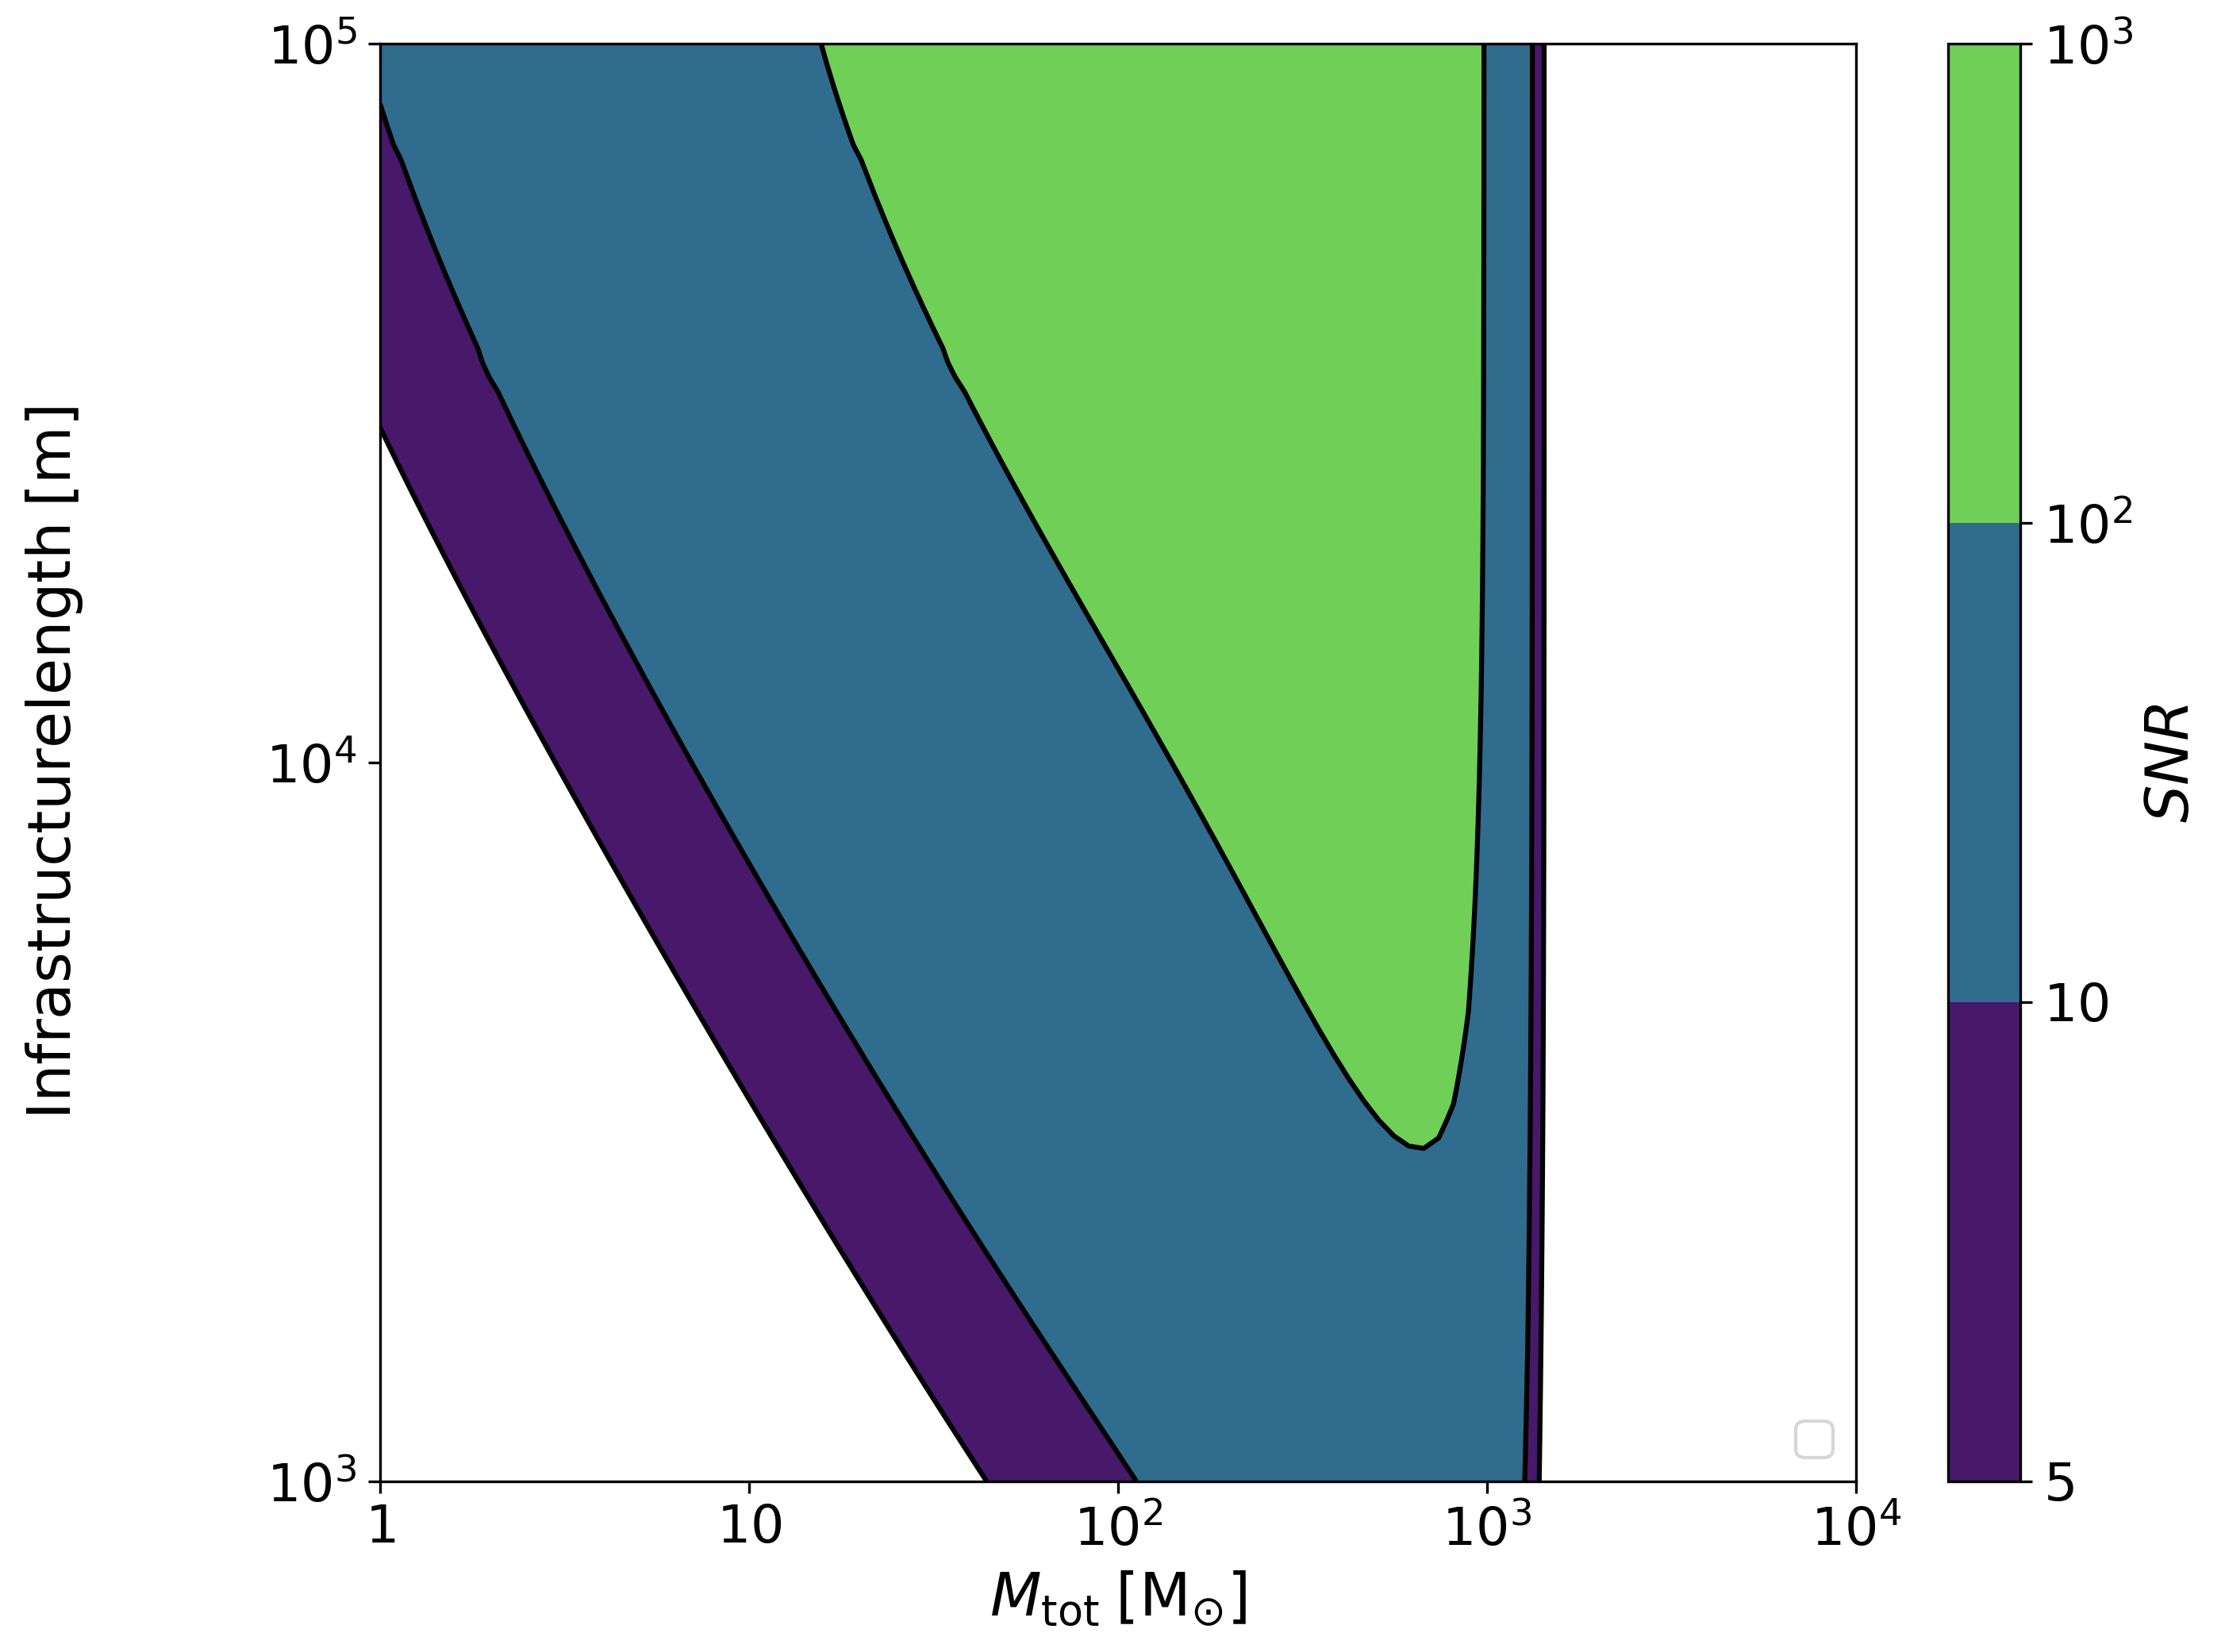

Model:  CE1_M_vs_Infrastructure_Length ,  done. t = :  142.10193586349487


In [84]:
for model in models:
    for var_y in var_ys:
        instrument = Get_Instrument(model)
        source = Get_Source(model)
        var_y_names = var_y.split()
        if len(var_y_names) == 1:
            #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '.png'
            save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_SNR_v2.txt'
            save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_samples_v2.txt'
        elif len(var_y_names) == 2:
            save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + \
            '_' + var_y_names[1] + '_SNR_v2.txt'
            save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + \
            '_' + var_y_names[1] + '_samples_v2.txt'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)

        if len(var_y_names) == 1:
            print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)
        elif len(var_y_names) == 2:
            print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y_names[0] + '_' + var_y_names[1],',',' done. t = : ',end-start)